In [ ]:

#| default_exp current


In [ ]:
#| hide
from nbdev.showdoc import *
import pandas as pd

In [ ]:
#| export
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Current Correction (current)

> Adjust speed through water for strength of current

This module represents the Appendix H of the ITTC, and provides the functionality to correct for current.

The current correction approaches can only really be used if the ITTC speed power process has been followed closely. The corrections require that there are multiple runs for several speed settings. This allows a regression to be made. If there is only one speed setting then the methods described in appendix H will not be applicable. 
If multiple double runs or runs at different speeds have not been performed then ship current sensors, met-ocean data, or other methods will have to be used.

## Which to choose?

Although the two methods are not mutually exlusive, they do have different minimum data gathering requirements in order to be used. 

- The iterative method can be used when the seatrial has performed a **SINGLE** set of double runs at **DIFFERENT** power settings
- The Mean of Means method can be performed when there have been **TWO** sets of double-runs at the **SAME** power setting

## Iterative Method

The iterative method assumes a current that varies with a semidurational period. This period is typically 12 hours, 25 minutes and 12 seconds, which can also be described as 0.51753 of a day. The function can use any speed unit and any unit of power although, the original ITTC documentation uses Knots and kWh respectively. 

The process for estimating the current and the true speed through water is described below.


### Step 1: Estimate the speed-power curve

Using the known speed over ground ($V_g$) values and observed power ($P_{obs}(V_s)$) values for each power/speed setting, find the coefficients of the equation

$$P(V_s) =a+ bV_s^q$$

Where:

- P(V_s) = the engine power at speed V_s
- a,b, q = unknown coefficients

### Step 2: Estimate speed through water from observed power and speed-power model

using the coefficients of the speed power mode and the observed power calculate and estimate of the necessary speed through water using 

$$V_s = \sqrt[q]{\frac{P(V_s)-a}{b}}$$

### Step 3: Estimate Current and current coefficients

Using $V_c = V_G - V_s$, get an estimate of $V_c$ for each speed setting and use it to find the coefficients of the following equation using leasts-squares

$$V_c = V_{C,C}\textrm{cos}(\frac{2\pi}{T_c}t) + V_{C,S}\textrm{sin}(\frac{2\pi}{T_c}t) + V_{C,T}t + V_{C,0}$$

Where:

- V_c = the current speed in knots
- T_c = is the period of variation of current speed, it is measured in hours
- t = the time for each run relative to the first run, it is measured in hours.
- $V_{C,C}, V_{C,S}, V_{C,T}, V_{C,0} =$ are unknown factors which found through iteration

Once the coefficients have been calculated the value of $V_c$ can be updated

### Step 4: Re-calculate the speed-power curve coefficients

Using the updated value of $V_c$ update the value of $V_s$ and re-calculate the parameters a.b and q for the speed power curve.

Using the new speed power curve and the estimated values of $V_s$ create the predicted values of engine power.

### Step 5: Measure the error between the observed and predicted Enginer power

Using the equation

$$SSE =\sum (P_{pred}(V_s)-P_{obs}(V_s))^2$$

measure the sum square error of the estimates. if the error is larger than tolerance go to Step 2, otherwise if the process has converged and the error minimised, finish and return the final values of $V_c$ and $V_s$

When setting the tolerance any small value is acceptable. typically a tolerance of $10^{-6}$ is used however values as large as $10^{-2}$ would probably have negligable impact on the final analysis


### Diagram

The below diagram provides a schematic of the process described above

```{mermaid}
graph LR;
  A(SOG) --> B(Step 1)
  Z(Power) -->B
  B --> C(Step 2)
  C --> D(Step 3)
  D --> E(Step 4)
  E --> L{Convergence?}
  L -- No --> C
  L -- Yes --> M[Return STW]
```

### Note:

This algorithm is not guarenteed to converge, nor is it guarenteed to reduce the square error each iteration. As such the function returns the current and power law parameters which produced the lowest error. It also returns a dataframe containing the error for each iteration

**ITTC equations:** H-1 to H-5 

This equation is not vectorised

In [ ]:
#| export
def estimate_speed_through_water(power:float, #The engine power, typically the 'ideal condition' is used [W]
                                 sog:float, #Speed over ground of the vessel [m/s] 
                                 t:float, #Time difference from current run to first run [hours]
                                 T_c:float, #Time duration period of the tide typically 12.42 hours [hours]
                                 tolerance:float=1, #The process terminates when the error falls below the specified threshold in Watts
                                 max_iter:float=1000, #Max imum number of iterations before process terminates
                                 p0:list = [0, 1, 3], #the initial guess for the power law coefficients they represent the expeonents a + bX^c [None]
                                 bounds:tuple = ([0, 0, 2.5], [5000, 20, 3.5]) #Bounds the power law equation to within realistic values
                                 )-> tuple: # Outputs a tuple of the stw, current, current coefficients, and speed power coefficints that minimised the error. Also returns a dataframe or the error per iteration
    
# Function to calculate current speed
    def current_speed(t, V_c_C, V_c_S, V_c_T, V_c_0, T_c):
        # Calculation using trigonometric functions and linear trend
        return V_c_C * np.cos((2 * np.pi / T_c) * t) + V_c_S * np.sin((2 * np.pi / T_c) * t) + V_c_T * t + V_c_0

    # Function for the power equation
    def power_eq(V_s, a, b, q):
        # Power equation with vessel speed as variable
        return a + b * V_s ** q

    # Get initial estimates for the power law curve parameters
    popt, _ = curve_fit(power_eq, sog, power, p0=p0, bounds=bounds)
    a, b, q = popt  # Destructure the parameters

    # Initialize variables for iterative process
    popt_v = [0, 0, 0, 0]
    iteration_results = []
    min_error = float('inf')
    best_popt = None
    best_popt_v = None

    # Iterative optimization process
    for i in range(max_iter):
        # Calculate vessel speed using power law equation
        V_s = np.power((power - a) / b, 1 / q)
        # Calculate current speed as the difference between SOG and vessel speed
        V_c = sog - V_s

        # Fit the current speed calculation to the data
        popt_v, _ = curve_fit(lambda t, V_c_C, V_c_S, V_c_T, V_c_0: current_speed(t, V_c_C, V_c_S, V_c_T, V_c_0, T_c), t, V_c, p0=popt_v)

        # Update current speed parameters
        V_c_C, V_c_S, V_c_T, V_c_0 = popt_v

        # Recalculate current speed with updated parameters
        V_c_new = current_speed(t, V_c_C, V_c_S, V_c_T, V_c_0, T_c)

        # Update vessel speed
        V_s = sog - V_c_new

        # Refit the power law equation with updated vessel speed
        popt, _ = curve_fit(power_eq, V_s, power, p0=[a, b, q], bounds=bounds)

        # Update power equation parameters
        a, b, q = popt

        # Calculate observed power and compute error
        P_obs = a + b * V_s ** q
        power_error = sum((P_obs - power) ** 2)

        # Store iteration results and check for minimum error
        iteration_results.append([i, power_error])
        if power_error < min_error:
            best_V_s = V_s
            best_V_c = V_c_new
            best_popt = (a, b, q)
            best_popt_v = (V_c_C, V_c_S, V_c_T, V_c_0)
            min_error = power_error

        # Break the loop if the error is within the tolerance
        if power_error < tolerance:
            break

    # Convert iteration results into a DataFrame
    df = pd.DataFrame(iteration_results, columns=["Iteration", "Power_Error"])

    return best_V_s, best_V_c, best_popt_v, best_popt, df

To help gain an intuitive understanding of the concept of the semidiurnal current, an example is plotted below. Not that the last terms in the current model (i.e. '$V_{C,T}t + V_{C,0}$') has no periodic component. This means that the iterative method can produce increasingly incorrect results over longer periods.

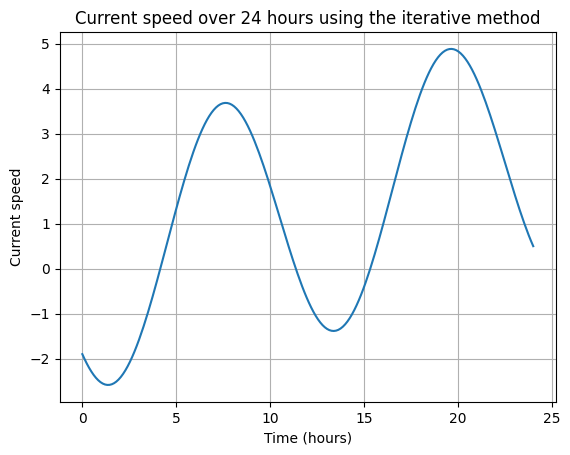

In [ ]:
T_c = 12
V_c_C=-2
V_c_S=-2
V_c_T=0.1
V_c_0=0.1

times = np.linspace(0, 24, 200)
current_speed = V_c_C * np.cos((2 * np.pi / T_c) * times) + V_c_S * np.sin((2 * np.pi / T_c) * times) + V_c_T * times + V_c_0

plt.plot(times, current_speed)
plt.xlabel('Time (hours)')
plt.ylabel('Current speed')
plt.title('Current speed over 24 hours using the iterative method')
plt.grid(True)
plt.show()

The example below demonstrates the process of identifying current speed using speed overground and the current equation. It should be noted that this method is an estimate only and as can be seen by the example can still produce a significant error.

Estimated speed through water: [ 3.36403099  7.8889879  13.11458325 19.03103214 25.44343601]
The error on the estimated speed through water is: [0.26403099 0.42103871 0.54663406 0.63103214 0.67548682]


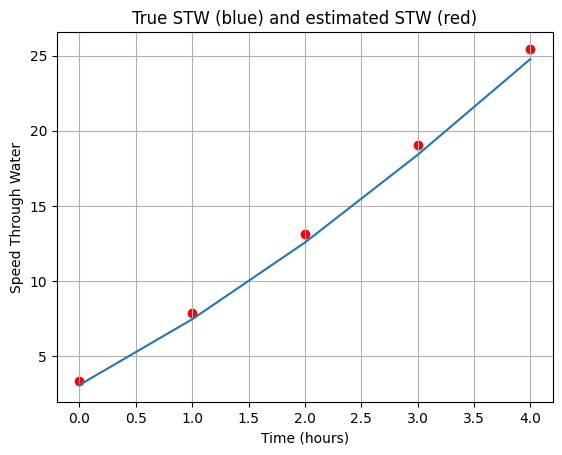

In [ ]:
T_c = 12
V_c_C=-2
V_c_S=-2
V_c_T=0.1
V_c_0=0.1

t = np.array([0, 1, 2, 3, 4])  # Time values relative to the first run
sog = np.array([5, 10, 15, 20, 25])
V_c_true = V_c_C * np.cos((2 * np.pi / T_c) * t) + V_c_S * np.sin((2 * np.pi / T_c) * t) + V_c_T * t + V_c_0
V_s_true = V_c_true + sog
a_true = 2
b_true = 3
c_true = 3
power = a_true + b_true * V_s_true ** c_true


stw, current_speed, _, _, error_df = estimate_speed_through_water(power, sog, t, T_c)
print("Estimated speed through water:", stw)

print("The error on the estimated speed through water is: "+str(stw-V_s_true) )


plt.plot(t, V_s_true)
plt.scatter(t, stw, color = 'red')

plt.xlabel('Time (hours)')
plt.ylabel('Speed Through Water')
plt.title('True STW (blue) and estimated STW (red)')
plt.grid(True)
plt.show()

The error on the calculation can also be visualised.

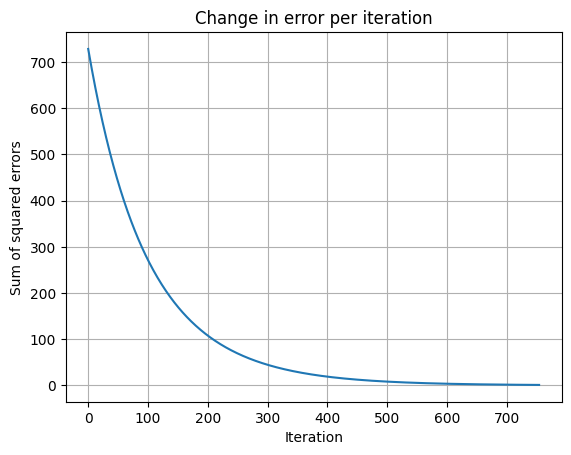

In [ ]:
plt.plot(error_df['Iteration'], error_df['Power_Error'])
plt.xlabel('Iteration')
plt.ylabel('Sum of squared errors')
plt.title('Change in error per iteration')
plt.grid(True)
plt.show()

## Mean of means method

Another approach to finding the current


$$V_s = \frac{V_{G1} + 3V_{G2}+ 3V_{G3} + V_{G4}}{8}$$

Where $V_s$ is the speed through water and  $V_{G1}$ to $V_{G4}$ are the mean speed over-ground for each double run at a given speed.

The current is assumed to have a parabolic form and as such can be expressed as 

$$V_c = V_{C,2} t^2 + V_{C,1} t +V_{C,1}$$

Where $V_c$ is the current speed, and $V_{C,2}$, $V_{C,1}$, $V_{C,0}$ are unknown factors.

The solution to the current equation can therefore be found by treating it as a system of linear equations of the form $y = X\beta$. The system of linear equations is shown below.

$$\begin{bmatrix}
    V_{G1} - V_s  \\
    V_{G2} - V_s  \\
    V_{G3} - V_s \\
    V_{G4} - V_s  \\
\end{bmatrix}
= 
\begin{bmatrix}
    (t + 3\Delta t)^2 & -(t + 3\Delta t) & 1 \\
    (t + \Delta t)^2 & -(t + \Delta t) & 1 \\
    (t - \Delta t)^2 & -(t - \Delta t) & 1 \\
    (t - 3\Delta t)^2 & -(t - 3\Delta t) & 1 \\
\end{bmatrix}
\cdot
\begin{bmatrix}
    V_{C,2}\\
    V_{C,1} \\
    V_{C,0} \\
\end{bmatrix} $$


This equation demonstrates the need to perform two double runs, i.e. 4 runs as this will result in four equations with the 3 uknowns of $V_{C,2}$, $V_{C,1}$, $V_{C,0}$. It should be noted that as current is not a parabola the values found should be used for interpolation not extrapolation. Setting the example below to 24 hours will produce terrifying torrents, which are obviously not realistic.

**ITTC equations:** H-6 to H-11

This equation is not vectorised

In [ ]:
#| export
def current_mean_of_means(sog: np.ndarray,  # The mean speed over ground across a double run,
                          start_time: float,  # Time in decimal hours when the first run took place,
                          time_between_runs: float  # Time in decimal hours between each run. Note the time difference must be consistent between all runs
                          ) -> float:  # Outputs a tuple of the stw vector, the current vector and the coefficients

    t = start_time
    delta_t = time_between_runs / 2

    V_G1, V_G2, V_G3, V_G4 = sog
    Vs = (V_G1 + 3 * V_G2 + 3 * V_G3 + V_G4) / 8

    A = np.array([[t + 3 * delta_t ** 2, -(t + 3 * delta_t), 1],
                  [t + 1 * delta_t ** 2, -(t + 1 * delta_t), 1],
                  [t - 1 * delta_t ** 2, -(t - 1 * delta_t), 1],
                  [t - 3 * delta_t ** 2, -(t - 3 * delta_t), 1]])

    b = np.array([V_G1 - Vs, V_G2 - Vs, V_G3 - Vs, V_G4 - Vs])

    coefs, residuals, rank, singular_values = np.linalg.lstsq(A, b, rcond=None)

    t_vect = np.array([0, time_between_runs, 2*time_between_runs, 3*time_between_runs])

    current = coefs[0] * t_vect**2 + coefs[1] * t_vect + coefs[2]

    stw = sog + current

    return stw, current, coefs 

In [ ]:
sog = np.array([10, 12.6, 12.6, 11])  # Mean speed over ground across a double run
start_time = 0.0  # Time in decimal hours when the first run took place
time_between_runs = 1  # Time in decimal hours between each run

stw, current, coefs= current_mean_of_means(sog, start_time, time_between_runs)
print("Current speed m/s:", current)

Current speed m/s: [-0.525 -0.405 -0.525 -0.885]


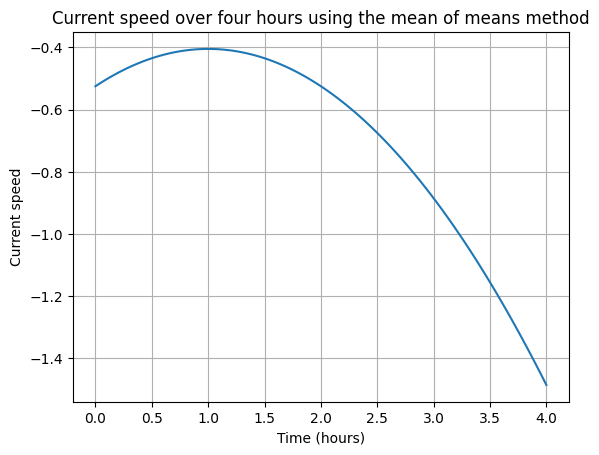

In [ ]:
def quadratic_function(t, coeffs):
    a, b, c = coeffs
    return a * t**2 + b * t + c

# Calculate the current speed throughout the day
times = np.linspace(0, 4, 100)  
current_strength = quadratic_function(times, coefs) 

# Plot the current speed over the 24-hour period
plt.plot(times, current_strength)
plt.xlabel('Time (hours)')
plt.ylabel('Current speed')
plt.title('Current speed over four hours using the mean of means method')
plt.grid(True)
plt.show()

In [ ]:
import nbdev; nbdev.nbdev_export()